# Ingeniería de Características

En esta sección, se describen las transformaciones y nuevas variables creadas para mejorar el rendimiento del modelo de clasificación de inmuebles de alto valor.

**Objetivo:** Crear features derivadas que capturen mejor las características que distinguen a los inmuebles de alto valor.

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings("ignore")

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

DATA_PATH = Path("../data/")
file_path = DATA_PATH / "processed/housing_with_score.csv"



In [20]:
# Cargar datos procesados del EDA
df = pd.read_csv(file_path)
print(f"Dataset cargado: {df.shape}")
print(f"\nColumnas ya creadas en EDA:")
print(f"  - Composite_Score")
print(f"  - High_Value")
print(f"  - Premium_Neighborhood")
print(f"\nDistribución de la variable objetivo:")
print(df['High_Value'].value_counts())
print(f"\nProporción: {df['High_Value'].value_counts(normalize=True)}")

Dataset cargado: (2930, 88)

Columnas ya creadas en EDA:
  - Composite_Score
  - High_Value
  - Premium_Neighborhood

Distribución de la variable objetivo:
High_Value
0    2197
1     733
Name: count, dtype: int64

Proporción: High_Value
0    0.749829
1    0.250171
Name: proportion, dtype: float64


## 1. Variables Temporales (Edad y Antigüedad)

In [24]:
# Edad de la propiedad
df['House_Age'] = df['Yr Sold'] - df['Year Built']

# Tiempo desde última remodelación
df['Years_Since_Remod'] = df['Yr Sold'] - df['Year Remod/Add']

# Indicador de si fue remodelada
df['Was_Remodeled'] = (df['Year Built'] != df['Year Remod/Add']).astype(int)

# Edad del garaje
df['Garage_Age'] = df['Yr Sold'] - df['Garage Yr Blt']
df['Garage_Age'] = df['Garage_Age'].fillna(0)

# Indicador de casa nueva (construida en año de venta o año anterior)
df['Is_New_House'] = (df['House_Age'] <= 1).astype(int)

print("=" * 80)
print("VARIABLES TEMPORALES CREADAS")
print("=" * 80)
print(f"\n1. House_Age:")
print(df['House_Age'].describe())
print(f"\n2. Years_Since_Remod:")
print(df['Years_Since_Remod'].describe())
print(f"\n3. Was_Remodeled:")
print(df['Was_Remodeled'].value_counts())
print(f"\n4. Is_New_House:")
print(df['Is_New_House'].value_counts())

VARIABLES TEMPORALES CREADAS

1. House_Age:
count    2930.000000
mean       36.434130
std        30.291357
min        -1.000000
25%         7.000000
50%        34.000000
75%        54.000000
max       136.000000
Name: House_Age, dtype: float64

2. Years_Since_Remod:
count    2930.000000
mean       23.523891
std        20.858846
min        -2.000000
25%         4.000000
50%        15.000000
75%        42.750000
max        60.000000
Name: Years_Since_Remod, dtype: float64

3. Was_Remodeled:
Was_Remodeled
0    1569
1    1361
Name: count, dtype: int64

4. Is_New_House:
Is_New_House
0    2595
1     335
Name: count, dtype: int64


## 2. Variables de Área Total y Ratios

In [26]:
# Área total habitable (incluyendo sótano)
df['Total_Living_Area'] = df['Gr Liv Area'] + df['Total Bsmt SF']

# Área total incluyendo garaje
df['Total_Area_Including_Garage'] = df['Total_Living_Area'] + df['Garage Area']

# Ratio de área de sótano respecto a área habitable
df['Basement_Ratio'] = df['Total Bsmt SF'] / (df['Gr Liv Area'] + 1)

# Ratio de área de garaje respecto a área habitable
df['Garage_Ratio'] = df['Garage Area'] / (df['Gr Liv Area'] + 1)

# Ratio de primer piso vs segundo piso
df['First_Second_Ratio'] = df['1st Flr SF'] / (df['2nd Flr SF'] + 1)

# Área promedio por habitación
df['Area_Per_Room'] = df['Gr Liv Area'] / (df['TotRms AbvGrd'] + 1)

# Densidad de construcción (área habitable / tamaño del lote)
df['Building_Density'] = df['Gr Liv Area'] / (df['Lot Area'] + 1)

print("=" * 80)
print("VARIABLES DE ÁREA Y RATIOS CREADAS")
print("=" * 80)
print(f"\n1. Total_Living_Area:")
print(df['Total_Living_Area'].describe())
print(f"\n2. Basement_Ratio:")
print(df['Basement_Ratio'].describe())
print(f"\n3. Building_Density:")
print(df['Building_Density'].describe())

VARIABLES DE ÁREA Y RATIOS CREADAS

1. Total_Living_Area:
count     2930.000000
mean      2550.946075
std        805.253248
min        334.000000
25%       2004.000000
50%       2452.000000
75%       2994.500000
max      11752.000000
Name: Total_Living_Area, dtype: float64

2. Basement_Ratio:
count    2930.000000
mean        0.732944
std         0.274081
min         0.000000
25%         0.499659
50%         0.777459
75%         0.998959
max         1.966871
Name: Basement_Ratio, dtype: float64

3. Building_Density:
count    2930.000000
mean        0.183045
std         0.115305
min         0.009459
25%         0.119494
50%         0.155977
75%         0.200536
max         1.043041
Name: Building_Density, dtype: float64


## 3. Variables de Baños y Habitaciones

In [27]:
# Total de baños completos
df['Total_Full_Baths'] = df['Bsmt Full Bath'] + df['Full Bath']

# Total de medio baños
df['Total_Half_Baths'] = df['Bsmt Half Bath'] + df['Half Bath']

# Total de baños (completos cuentan como 1, medios como 0.5)
df['Total_Bathrooms'] = df['Total_Full_Baths'] + (df['Total_Half_Baths'] * 0.5)

# Ratio baños/habitaciones
df['Bath_Bedroom_Ratio'] = df['Total_Bathrooms'] / (df['Bedroom AbvGr'] + 1)

# Indicador de múltiples baños (2+)
df['Has_Multiple_Baths'] = (df['Total_Full_Baths'] >= 2).astype(int)

# Total de habitaciones + baños
df['Total_Rooms_Baths'] = df['TotRms AbvGrd'] + df['Total_Bathrooms']

print("=" * 80)
print("VARIABLES DE BAÑOS Y HABITACIONES CREADAS")
print("=" * 80)
print(f"\n1. Total_Bathrooms:")
print(df['Total_Bathrooms'].describe())
print(f"\n2. Bath_Bedroom_Ratio:")
print(df['Bath_Bedroom_Ratio'].describe())
print(f"\n3. Has_Multiple_Baths:")
print(df['Has_Multiple_Baths'].value_counts())

VARIABLES DE BAÑOS Y HABITACIONES CREADAS

1. Total_Bathrooms:
count    2928.000000
mean        2.217896
std         0.807059
min         1.000000
25%         1.500000
50%         2.000000
75%         2.500000
max         7.000000
Name: Total_Bathrooms, dtype: float64

2. Bath_Bedroom_Ratio:
count    2928.000000
mean        0.597626
std         0.256150
min         0.166667
25%         0.400000
50%         0.583333
75%         0.700000
max         3.000000
Name: Bath_Bedroom_Ratio, dtype: float64

3. Has_Multiple_Baths:
Has_Multiple_Baths
1    2170
0     760
Name: count, dtype: int64


## 4. Indicadores de Características de Lujo

In [28]:
# Tiene piscina
df['Has_Pool'] = (df['Pool Area'] > 0).astype(int)

# Tiene chimenea
df['Has_Fireplace'] = (df['Fireplaces'] > 0).astype(int)

# Tiene garaje
df['Has_Garage'] = (df['Garage Cars'] > 0).astype(int)

# Tiene sótano
df['Has_Basement'] = (df['Total Bsmt SF'] > 0).astype(int)

# Tiene deck o porch
df['Has_Deck_Porch'] = ((df['Wood Deck SF'] > 0) | 
                        (df['Open Porch SF'] > 0) | 
                        (df['Enclosed Porch'] > 0) | 
                        (df['Screen Porch'] > 0)).astype(int)

# Área total de espacios exteriores
df['Total_Outdoor_SF'] = (df['Wood Deck SF'] + df['Open Porch SF'] + 
                          df['Enclosed Porch'] + df['3Ssn Porch'] + 
                          df['Screen Porch'])

# Garaje grande (3+ autos)
df['Has_Large_Garage'] = (df['Garage Cars'] >= 3).astype(int)

# Score de lujo (suma de indicadores)
df['Luxury_Score'] = (df['Has_Pool'] + df['Has_Fireplace'] + 
                      df['Has_Large_Garage'] + df['Has_Deck_Porch'] + 
                      (df['Total_Full_Baths'] >= 3).astype(int))

print("=" * 80)
print("INDICADORES DE LUJO CREADOS")
print("=" * 80)
print(f"\n1. Has_Pool: {df['Has_Pool'].sum()} ({df['Has_Pool'].mean():.1%})")
print(f"2. Has_Fireplace: {df['Has_Fireplace'].sum()} ({df['Has_Fireplace'].mean():.1%})")
print(f"3. Has_Large_Garage: {df['Has_Large_Garage'].sum()} ({df['Has_Large_Garage'].mean():.1%})")
print(f"4. Has_Deck_Porch: {df['Has_Deck_Porch'].sum()} ({df['Has_Deck_Porch'].mean():.1%})")
print(f"\n5. Luxury_Score distribution:")
print(df['Luxury_Score'].value_counts().sort_index())

INDICADORES DE LUJO CREADOS

1. Has_Pool: 13 (0.4%)
2. Has_Fireplace: 1508 (51.5%)
3. Has_Large_Garage: 391 (13.3%)
4. Has_Deck_Porch: 2438 (83.2%)

5. Luxury_Score distribution:
Luxury_Score
0    334
1    992
2    965
3    437
4    200
5      2
Name: count, dtype: int64


## 5. Variables de Calidad Agregada

In [29]:
# Score de calidad total (suma de calidades ordinales ya convertidas)
quality_vars = ['Kitchen Qual_num', 'Exter Qual_num', 'Bsmt Qual_num']
df['Total_Quality_Score'] = df[quality_vars].sum(axis=1)

# Score de calidad promedio
df['Avg_Quality_Score'] = df['Total_Quality_Score'] / len(quality_vars)

# Indicador de alta calidad general (Overall Qual >= 7)
df['Is_High_Quality'] = (df['Overall Qual'] >= 7).astype(int)

# Indicador de excelente calidad (Overall Qual >= 8)
df['Is_Excellent_Quality'] = (df['Overall Qual'] >= 8).astype(int)

# Score combinado de calidad y condición
df['Quality_Condition_Score'] = df['Overall Qual'] + df['Overall Cond']

print("=" * 80)
print("VARIABLES DE CALIDAD AGREGADA CREADAS")
print("=" * 80)
print(f"\n1. Total_Quality_Score:")
print(df['Total_Quality_Score'].describe())
print(f"\n2. Is_High_Quality:")
print(df['Is_High_Quality'].value_counts())
print(f"\n3. Is_Excellent_Quality:")
print(df['Is_Excellent_Quality'].value_counts())

VARIABLES DE CALIDAD AGREGADA CREADAS

1. Total_Quality_Score:
count    2930.000000
mean       10.388737
std         1.836267
min         4.000000
25%         9.000000
50%        10.000000
75%        12.000000
max        15.000000
Name: Total_Quality_Score, dtype: float64

2. Is_High_Quality:
Is_High_Quality
0    1840
1    1090
Name: count, dtype: int64

3. Is_Excellent_Quality:
Is_Excellent_Quality
0    2442
1     488
Name: count, dtype: int64


## 6. Variables de Tipo de Propiedad y Estilo

In [30]:
# Indicador de casa unifamiliar
df['Is_Single_Family'] = (df['Bldg Type'] == '1Fam').astype(int)

# Indicador de casa de 2 pisos
df['Is_Two_Story'] = (df['House Style'].isin(['2Story', '2.5Fin', '2.5Unf'])).astype(int)

# Indicador de casa de 1 piso
df['Is_One_Story'] = (df['House Style'].isin(['1Story', '1.5Fin', '1.5Unf'])).astype(int)

# Zonificación residencial de baja densidad (premium)
df['Is_Residential_Low_Density'] = (df['MS Zoning'] == 'RL').astype(int)

print("=" * 80)
print("VARIABLES DE TIPO DE PROPIEDAD CREADAS")
print("=" * 80)
print(f"\n1. Is_Single_Family: {df['Is_Single_Family'].sum()} ({df['Is_Single_Family'].mean():.1%})")
print(f"2. Is_Two_Story: {df['Is_Two_Story'].sum()} ({df['Is_Two_Story'].mean():.1%})")
print(f"3. Is_Residential_Low_Density: {df['Is_Residential_Low_Density'].sum()} ({df['Is_Residential_Low_Density'].mean():.1%})")

VARIABLES DE TIPO DE PROPIEDAD CREADAS

1. Is_Single_Family: 2425 (82.8%)
2. Is_Two_Story: 905 (30.9%)
3. Is_Residential_Low_Density: 2273 (77.6%)


## 7. Variables de Interacción

In [31]:
# Interacción: Calidad x Tamaño
df['Quality_x_Size'] = df['Overall Qual'] * df['Gr Liv Area']

# Interacción: Barrio Premium x Calidad
df['Premium_Neighborhood_x_Quality'] = df['Premium_Neighborhood'] * df['Overall Qual']

# Interacción: Edad x Calidad (casas nuevas de calidad)
df['New_x_Quality'] = df['Is_New_House'] * df['Overall Qual']

# Interacción: Área x Baños (casas grandes con muchos baños)
df['Area_x_Bathrooms'] = df['Gr Liv Area'] * df['Total_Bathrooms']

print("=" * 80)
print("VARIABLES DE INTERACCIÓN CREADAS")
print("=" * 80)
print(f"\n1. Quality_x_Size:")
print(df['Quality_x_Size'].describe())
print(f"\n2. Premium_Neighborhood_x_Quality:")
print(df['Premium_Neighborhood_x_Quality'].describe())

VARIABLES DE INTERACCIÓN CREADAS

1. Quality_x_Size:
count     2930.000000
mean      9547.264846
std       4997.167912
min        334.000000
25%       5917.000000
50%       8640.000000
75%      11966.750000
max      56420.000000
Name: Quality_x_Size, dtype: float64

2. Premium_Neighborhood_x_Quality:
count    2930.000000
mean        1.507167
std         3.107736
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000
Name: Premium_Neighborhood_x_Quality, dtype: float64


## 8. Variables Binarias para Condiciones de Venta

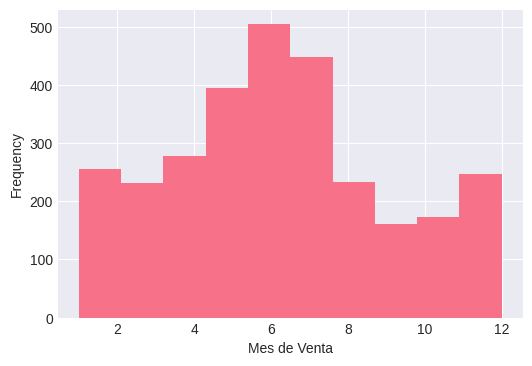

In [32]:
# histogram of Mo Sold
fig, ax = plt.subplots(figsize=(6, 4))
df['Mo Sold'].plot(kind='hist', ax=ax)
ax.set_xlabel('Mes de Venta')
plt.show()

In [33]:
# Venta normal (sin condiciones anormales)
df['Is_Normal_Sale'] = (df['Sale Condition'] == 'Normal').astype(int)

# Venta parcial (casa nueva no terminada)
df['Is_Partial_Sale'] = (df['Sale Condition'] == 'Partial').astype(int)

# Venta anormal
df['Is_Abnormal_Sale'] = (df['Sale Condition'] == 'Abnorml').astype(int)

# Mes de venta (temporada alta: Mayo-Julio)
df['Is_Peak_Season'] = df['Mo Sold'].isin([5, 6, 7]).astype(int)

print("=" * 80)
print("VARIABLES DE CONDICIONES DE VENTA CREADAS")
print("=" * 80)
print(f"\n1. Is_Normal_Sale: {df['Is_Normal_Sale'].sum()} ({df['Is_Normal_Sale'].mean():.1%})")
print(f"2. Is_Partial_Sale: {df['Is_Partial_Sale'].sum()} ({df['Is_Partial_Sale'].mean():.1%})")
print(f"3. Is_Peak_Season: {df['Is_Peak_Season'].sum()} ({df['Is_Peak_Season'].mean():.1%})")

VARIABLES DE CONDICIONES DE VENTA CREADAS

1. Is_Normal_Sale: 2413 (82.4%)
2. Is_Partial_Sale: 245 (8.4%)
3. Is_Peak_Season: 1349 (46.0%)


## 9. Resumen de Features Creadas

In [34]:
# Lista de nuevas features creadas
new_features = [
    # Temporales
    'House_Age', 'Years_Since_Remod', 'Was_Remodeled', 'Garage_Age', 'Is_New_House',
    
    # Áreas y Ratios
    'Total_Living_Area', 'Total_Area_Including_Garage', 'Basement_Ratio', 
    'Garage_Ratio', 'First_Second_Ratio', 'Area_Per_Room', 'Building_Density',
    
    # Baños y Habitaciones
    'Total_Full_Baths', 'Total_Half_Baths', 'Total_Bathrooms', 
    'Bath_Bedroom_Ratio', 'Has_Multiple_Baths', 'Total_Rooms_Baths',
    
    # Lujo
    'Has_Pool', 'Has_Fireplace', 'Has_Garage', 'Has_Basement', 
    'Has_Deck_Porch', 'Total_Outdoor_SF', 'Has_Large_Garage', 'Luxury_Score',
    
    # Calidad
    'Total_Quality_Score', 'Avg_Quality_Score', 'Is_High_Quality', 
    'Is_Excellent_Quality', 'Quality_Condition_Score',
    
    # Tipo de Propiedad
    'Is_Single_Family', 'Is_Two_Story', 'Is_One_Story', 'Is_Residential_Low_Density',
    
    # Interacciones
    'Quality_x_Size', 'Premium_Neighborhood_x_Quality', 
    'New_x_Quality', 'Area_x_Bathrooms',
    
    # Condiciones de Venta
    'Is_Normal_Sale', 'Is_Partial_Sale', 'Is_Abnormal_Sale', 'Is_Peak_Season'
]

print("=" * 80)
print("RESUMEN DE FEATURE ENGINEERING")
print("=" * 80)
print(f"\nTotal de features creadas: {len(new_features)}")
print(f"\nCategorías:")
print(f"  - Temporales: 5")
print(f"  - Áreas y Ratios: 7")
print(f"  - Baños y Habitaciones: 6")
print(f"  - Indicadores de Lujo: 8")
print(f"  - Calidad Agregada: 5")
print(f"  - Tipo de Propiedad: 4")
print(f"  - Interacciones: 4")
print(f"  - Condiciones de Venta: 4")
print(f"\nShape del dataset: {df.shape}")

RESUMEN DE FEATURE ENGINEERING

Total de features creadas: 43

Categorías:
  - Temporales: 5
  - Áreas y Ratios: 7
  - Baños y Habitaciones: 6
  - Indicadores de Lujo: 8
  - Calidad Agregada: 5
  - Tipo de Propiedad: 4
  - Interacciones: 4
  - Condiciones de Venta: 4

Shape del dataset: (2930, 131)


## 10. Análisis de Correlación de Nuevas Features con Variable Objetivo

TOP 15 FEATURES MÁS CORRELACIONADAS CON HIGH_VALUE
Premium_Neighborhood_x_Quality    0.839759
Is_Excellent_Quality              0.735857
Total_Quality_Score               0.660151
Avg_Quality_Score                 0.660151
Quality_x_Size                    0.642918
Is_High_Quality                   0.639606
Total_Area_Including_Garage       0.592739
Total_Living_Area                 0.556718
Luxury_Score                      0.554053
Has_Large_Garage                  0.524133
Area_x_Bathrooms                  0.522584
Area_Per_Room                     0.495822
Quality_Condition_Score           0.471412
Total_Bathrooms                   0.463379
Total_Full_Baths                  0.446693
Name: High_Value, dtype: float64


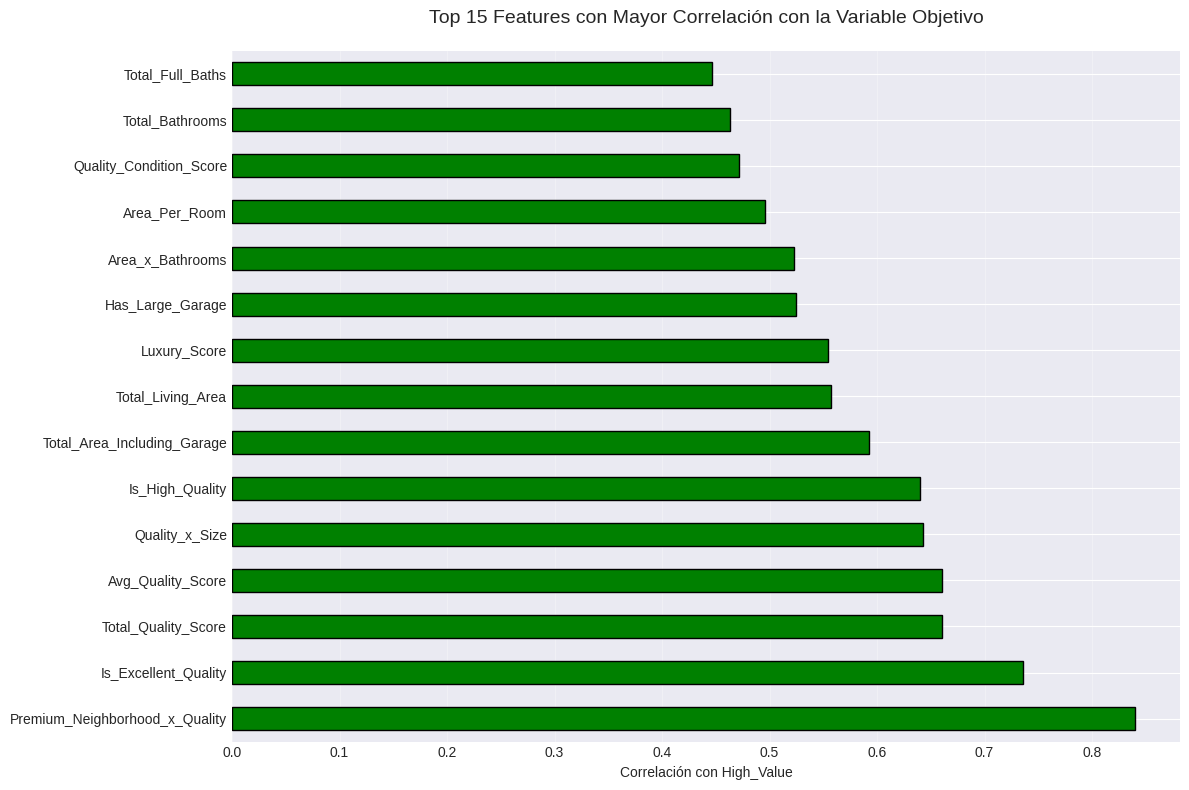

In [35]:
# Calcular correlaciones con High_Value
correlations = df[new_features + ['High_Value']].corr()['High_Value'].sort_values(ascending=False)

# Top 15 features más correlacionadas
print("=" * 80)
print("TOP 15 FEATURES MÁS CORRELACIONADAS CON HIGH_VALUE")
print("=" * 80)
print(correlations.head(16)[1:])  # Excluir High_Value consigo misma

# Visualización
fig, ax = plt.subplots(figsize=(12, 8))
top_corr = correlations.head(16)[1:]
colors = ['green' if x > 0 else 'red' for x in top_corr.values]
top_corr.plot(kind='barh', ax=ax, color=colors, edgecolor='black')
ax.set_xlabel('Correlación con High_Value')
ax.set_title('Top 15 Features con Mayor Correlación con la Variable Objetivo', fontsize=14, pad=20)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 11. Detección de Features con Alta Multicolinealidad

In [36]:
# Matriz de correlación entre nuevas features numéricas
numeric_features = [f for f in new_features if df[f].dtype in ['int64', 'float64']]
corr_matrix = df[numeric_features].corr()

# Encontrar pares altamente correlacionados (|r| > 0.8)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'Feature_1': corr_matrix.columns[i],
                'Feature_2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

print("=" * 80)
print("FEATURES CON ALTA CORRELACIÓN (|r| > 0.8)")
print("=" * 80)
if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print(high_corr_df.sort_values('Correlation', ascending=False, key=abs))
else:
    print("No se encontraron pares con correlación > 0.8")

FEATURES CON ALTA CORRELACIÓN (|r| > 0.8)
                      Feature_1                    Feature_2  Correlation
9           Total_Quality_Score            Avg_Quality_Score     1.000000
0                  Is_New_House                New_x_Quality     0.989080
1             Total_Living_Area  Total_Area_Including_Garage     0.982317
6              Total_Full_Baths              Total_Bathrooms     0.941007
4   Total_Area_Including_Garage               Quality_x_Size     0.883533
2             Total_Living_Area               Quality_x_Size     0.882093
11               Quality_x_Size             Area_x_Bathrooms     0.867273
7               Total_Bathrooms             Area_x_Bathrooms     0.862348
10                 Is_Two_Story                 Is_One_Story    -0.852311
8             Total_Rooms_Baths             Area_x_Bathrooms     0.850915
3             Total_Living_Area             Area_x_Bathrooms     0.818350
5   Total_Area_Including_Garage             Area_x_Bathrooms     0.814

## 12. Análisis por Grupo: Alto Valor vs No Alto Valor

COMPARACIÓN DE FEATURES CLAVE ENTRE GRUPOS
           House_Age            Total_Living_Area             Total_Bathrooms  \
                mean        std              mean         std            mean   
High_Value                                                                      
0           44.94447  28.478983       2292.046882  589.581110        2.001822   
1           10.92633  19.221033       3326.937244  864.659753        2.864939   

                     Luxury_Score           Total_Quality_Score            \
                 std         mean       std                mean       std   
High_Value                                                                  
0           0.726498     1.378698  0.845788            9.688666  1.399494   
1           0.680655     2.747613  1.015124           12.487040  1.317768   

           Has_Large_Garage           Is_Excellent_Quality            \
                       mean       std                 mean       std   
High_Value           

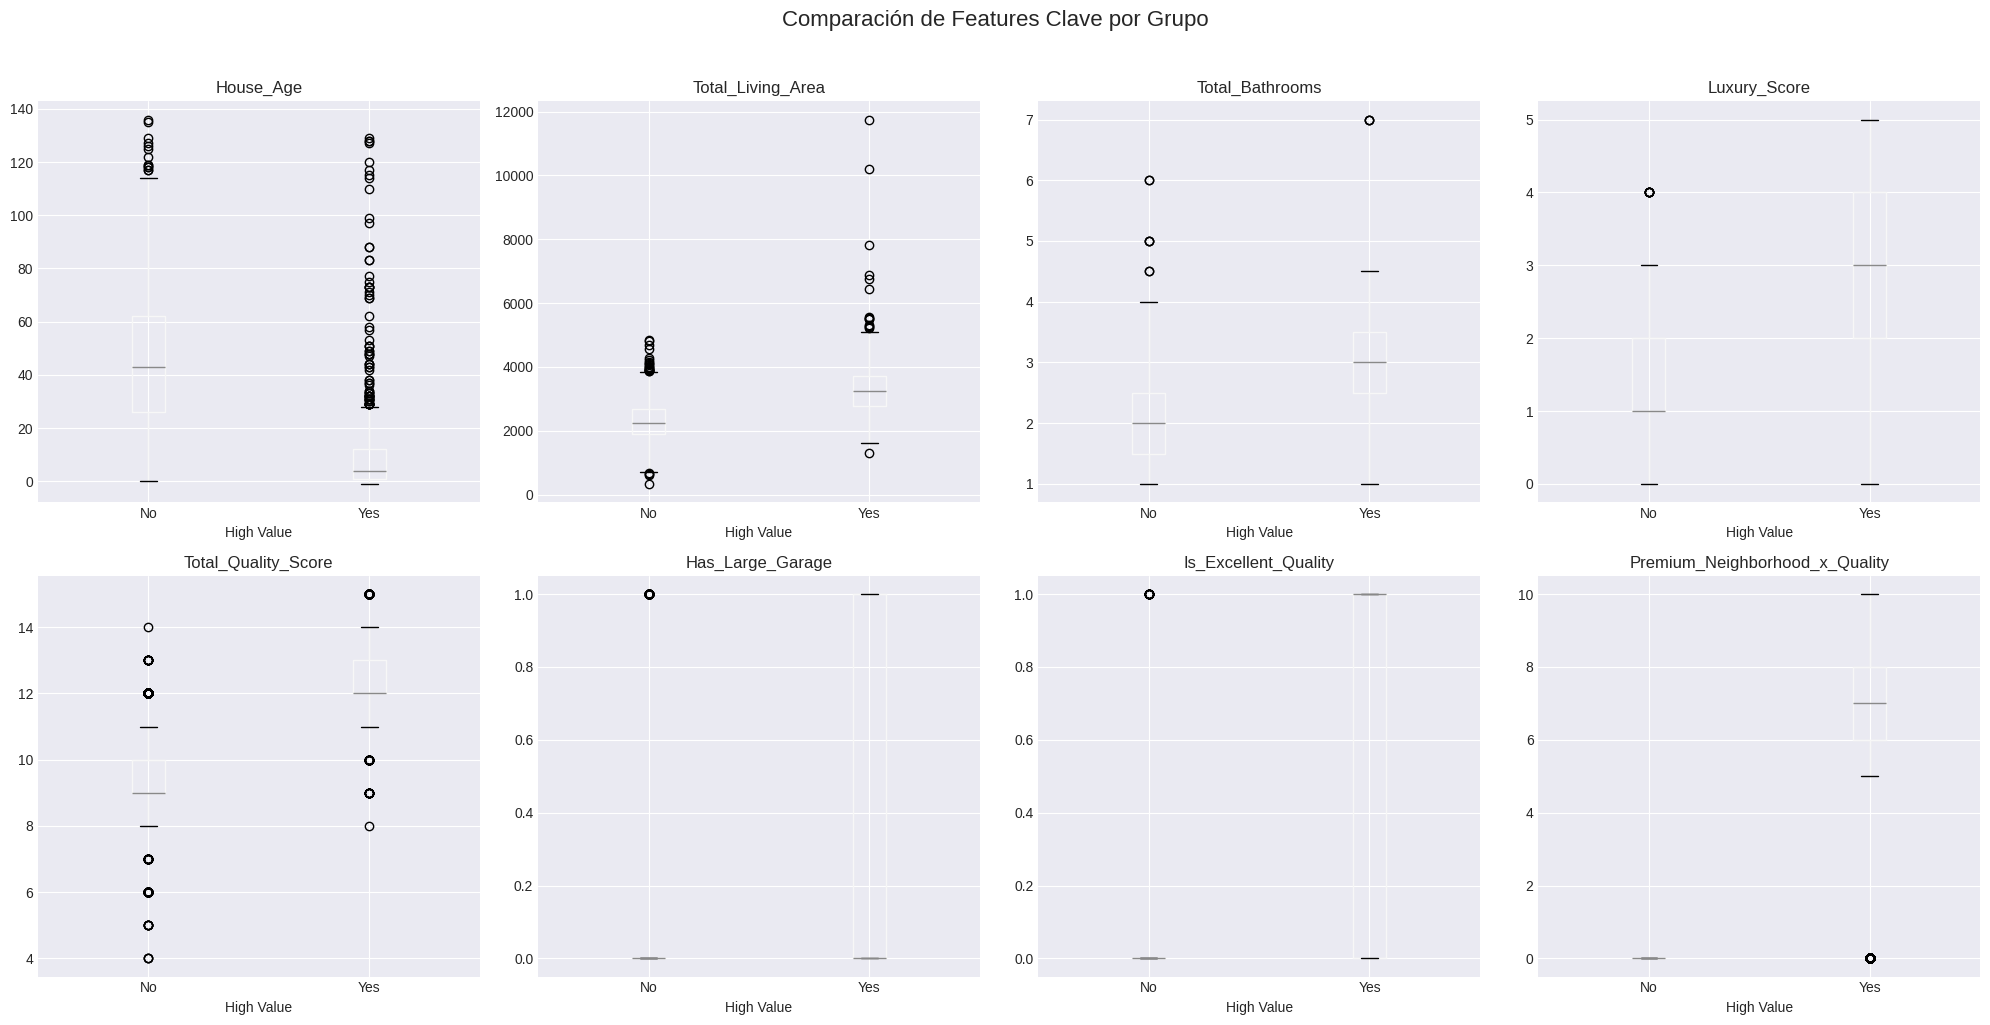

In [37]:
# Comparación de medias para features clave
key_features = [
    'House_Age', 'Total_Living_Area', 'Total_Bathrooms', 
    'Luxury_Score', 'Total_Quality_Score', 'Has_Large_Garage',
    'Is_Excellent_Quality', 'Premium_Neighborhood_x_Quality'
]

comparison = df.groupby('High_Value')[key_features].agg(['mean', 'std'])

print("=" * 80)
print("COMPARACIÓN DE FEATURES CLAVE ENTRE GRUPOS")
print("=" * 80)
print(comparison)

# Visualización
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    df.boxplot(column=feature, by='High_Value', ax=axes[idx])
    axes[idx].set_title(f'{feature}')
    axes[idx].set_xlabel('High Value')
    plt.sca(axes[idx])
    plt.xticks([1, 2], ['No', 'Yes'])

plt.suptitle('Comparación de Features Clave por Grupo', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 13. Guardar Dataset con Features seleccionadas

In [38]:
# Guardar dataset procesado
output_path = DATA_PATH / "processed" / "housing_engineered_features.csv"
df_features = df[new_features + ['High_Value']]
df_features.to_csv(output_path, index=False)

print("=" * 80)
print("DATASET GUARDADO")
print("=" * 80)
print(f"Archivo: {output_path}")
print(f"Shape: {df_features.shape}")
print(f"\nColumnas totales: {len(df_features.columns)}")
print(f"Features creadas: {len(new_features)}")
print(f"\nPrimeras columnas:")
print(df_features.columns[:10].tolist())


DATASET GUARDADO
Archivo: ../data/processed/housing_engineered_features.csv
Shape: (2930, 44)

Columnas totales: 44
Features creadas: 43

Primeras columnas:
['House_Age', 'Years_Since_Remod', 'Was_Remodeled', 'Garage_Age', 'Is_New_House', 'Total_Living_Area', 'Total_Area_Including_Garage', 'Basement_Ratio', 'Garage_Ratio', 'First_Second_Ratio']


## Resumen de Feature Engineering

### Features Creadas por Categoría:

**1. Variables Temporales (5 features)**
- `House_Age`: Edad de la casa en años
- `Years_Since_Remod`: Años desde última remodelación
- `Was_Remodeled`: Indicador binario de remodelación
- `Garage_Age`: Edad del garaje
- `Is_New_House`: Casa construida recientemente (≤1 año)

**2. Áreas y Ratios (7 features)**
- `Total_Living_Area`: Área habitable total
- `Total_Area_Including_Garage`: Área total incluyendo garaje
- `Basement_Ratio`: Proporción sótano/área habitable
- `Garage_Ratio`: Proporción garaje/área habitable
- `First_Second_Ratio`: Ratio primer piso/segundo piso
- `Area_Per_Room`: Área promedio por habitación
- `Building_Density`: Densidad de construcción en el lote

**3. Baños y Habitaciones (6 features)**
- `Total_Full_Baths`: Total de baños completos
- `Total_Half_Baths`: Total de medio baños
- `Total_Bathrooms`: Total de baños (weighted)
- `Bath_Bedroom_Ratio`: Ratio baños/habitaciones
- `Has_Multiple_Baths`: Indicador de múltiples baños
- `Total_Rooms_Baths`: Total de habitaciones + baños

**4. Indicadores de Lujo (8 features)**
- `Has_Pool`, `Has_Fireplace`, `Has_Garage`, `Has_Basement`
- `Has_Deck_Porch`: Tiene espacios exteriores
- `Total_Outdoor_SF`: Área total exterior
- `Has_Large_Garage`: Garaje grande (3+ autos)
- `Luxury_Score`: Score agregado de características de lujo

**5. Calidad Agregada (5 features)**
- `Total_Quality_Score`: Suma de scores de calidad
- `Avg_Quality_Score`: Promedio de calidad
- `Is_High_Quality`: Calidad general alta (≥7)
- `Is_Excellent_Quality`: Calidad excelente (≥8)
- `Quality_Condition_Score`: Score combinado calidad+condición

**6. Tipo de Propiedad (4 features)**
- `Is_Single_Family`: Casa unifamiliar
- `Is_Two_Story`: Casa de dos pisos
- `Is_One_Story`: Casa de un piso
- `Is_Residential_Low_Density`: Zonificación RL

**7. Interacciones (4 features)**
- `Quality_x_Size`: Calidad × Tamaño
- `Premium_Neighborhood_x_Quality`: Barrio premium × Calidad
- `New_x_Quality`: Casa nueva × Calidad
- `Area_x_Bathrooms`: Área × Baños

**8. Condiciones de Venta (4 features)**
- `Is_Normal_Sale`: Venta normal
- `Is_Partial_Sale`: Venta parcial
- `Is_Abnormal_Sale`: Venta anormal
- `Is_Peak_Season`: Temporada alta (Mayo-Julio)

### Total: 43 nuevas features creadas

**Próximos pasos:**
1. Selección de features basada en importancia y correlación
2. Tratamiento de valores faltantes
3. Encoding de variables categóricas remanentes
4. Escalado de features numéricas
5. División en train/test y preparación para modelado